In [1]:
%pip install numpy Pillow scipy matplotlib h5py nibabel tqdm

  Using cached numpy-2.2.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached pillow-11.1.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (9.1 kB)
  Using cached scipy-1.15.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached matplotlib-3.10.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached nibabel-5.3.2-py3-none-any.whl.metadata (9.1 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached contourpy-1.3.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.56.0-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (101 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached pyparsing-3.2.1-py3-none-any.w

In [2]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from PIL import Image
import subprocess
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
import random

In [3]:
DATA = "data/Mouse/BNL_NHMFL_Ex-vivo/Atlas_C57_7_exvivo.nii"

In [5]:
def load_mri(mri_filepath, normalize=False, standardize=False):
    """Load a 3D MRI scan from a .nii file and normalize/standardize."""
    # Load MRI using nibabel
    img = nib.load(mri_filepath)
    img_data = img.get_fdata()  # This returns a numpy array of shape (X, Y, Z)

    if img_data.shape[-1] == 1:
        img_data = img_data.squeeze(-1)
    
    # Normalize the data to [0, 1]
    if normalize:
        img_data -= np.min(img_data)
        img_data /= np.max(img_data)
    
    # Standardize the data to have mean 0 and std 1
    if standardize:
        mean = np.mean(img_data)
        std = np.std(img_data)
        img_data = (img_data - mean) / (std + 1e-5)
    
    img_data = np.expand_dims(img_data, axis=-1)
    
    return img_data

In [6]:
img = load_mri(DATA)

In [7]:
type(img), img.shape

(numpy.memmap, (256, 256, 512, 1))

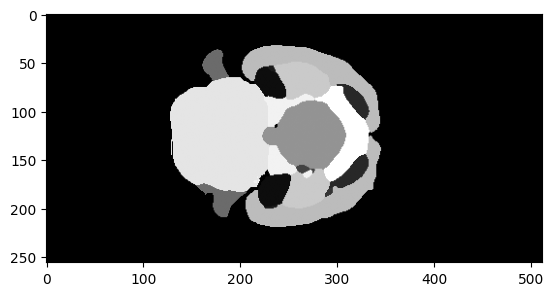

In [8]:
plt.imshow(img[:,128,:, 0], cmap='gray')

In [9]:
def process_single_file(file_name, input_data, output_keypoint_images):
    """
    Processes a single .nii file by constructing the command and running it.
    """
    input_file_path = os.path.join(input_data, file_name)
    output_file_name = file_name.replace('.nii', '.key')
    output_file_path = os.path.join(output_keypoint_images, output_file_name)
    command = ['./featExtract.ubu', '-w', input_file_path, output_file_path]
    
    try:
        result = subprocess.run(command, check=True, capture_output=True, text=True)
        # print(f"Successfully processed {file_name}")
    except subprocess.CalledProcessError as e:
        print(f"Error processing {file_name}: {e.stderr}")

def process_nii_files(input_data, output_keypoint_images):
    """
    Processes all .nii files in the input folder in parallel and generates corresponding .key files in the output folder.
    """
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_keypoint_images):
        os.makedirs(output_keypoint_images)
    
    # Get the list of all .nii files in the input folder
    nii_files = [file for file in os.listdir(input_data) if file.endswith('.nii')]
    
    # Use a ProcessPoolExecutor to process files in parallel
    with ProcessPoolExecutor() as executor:
        # Submit all files for processing
        futures = {
            executor.submit(process_single_file, file_name, input_data, output_keypoint_images): file_name
            for file_name in nii_files
        }
        # Use tqdm to display progress as futures complete
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing files", unit="file"):
            try:
                future.result()  # Raises exception if one occurred in process_single_file
            except Exception as e:
                print(f"Error occurred: {e}")


In [10]:
input_data = "data/Macaque"
output_keypoint_images = "data/Macaque/keyFiles"  # Change if you want to save in a different folder
process_nii_files(input_data, output_keypoint_images)

Processing files: 100%|██████████| 2/2 [01:20<00:00, 40.22s/file]


In [12]:
import key2vtk

key2vtk.run_processing(
    base_path="~/Desktop/Experiments/brainSIFT/data/Macaque",
    key_subdir="keyFiles",
    vtk_subdir="vtk"
)

2025-04-28 13:33:31,217 - WARNING - Duplicate positions found in /home/aryanshukla/Desktop/Experiments/brainSIFT/data/Macaque/keyFiles/mri_rb.key:               X          Y          Z     Scale       o11       o12       o13  \
0     36.159275  14.659267  12.844195  0.618748 -0.851466  0.211090 -0.480048   
1     36.159275  14.659267  12.844195  0.618748  0.852248 -0.407694  0.327809   
2     35.445946  13.845456  14.345050  0.595950 -0.211480  0.741921 -0.636262   
3     35.445946  13.845456  14.345050  0.595950 -0.196263 -0.545855  0.814569   
4     35.445946  13.845456  14.345050  0.595950 -0.196263 -0.545855  0.814569   
...         ...        ...        ...       ...       ...       ...       ...   
2850  24.206377  22.427460  47.625584  3.076865  0.084152 -0.596864 -0.797917   
2851  24.206377  22.427460  47.625584  3.076865  0.084152 -0.596864 -0.797917   
2852  24.206377  22.427460  47.625584  3.076865  0.084152 -0.596864 -0.797917   
2853  26.870520  36.341282  48.720959  3.64

Number of positive features: 413
Number of negative features: 414
Number of positive features: 413
Number of negative features: 414
Number of positive features: 0
Number of negative features: 0


2025-04-28 13:34:02,309 - WARNING - Duplicate positions found in /home/aryanshukla/Desktop/Experiments/brainSIFT/data/Macaque/keyFiles/macaque_25_model-MNI.key:              X          Y          Z     Scale       o11       o12       o13  \
0    -7.414948  16.729168 -19.695988  1.115810 -0.864565  0.257775  0.431370   
1    -7.414948  16.729168 -19.695988  1.115810  0.863672  0.339207 -0.372840   
2    -7.414948  16.729168 -19.695988  1.115810  0.436402  0.630015  0.642366   
3    -0.418034  13.785713 -19.593750  1.083080 -0.920286  0.390657 -0.021470   
4    -0.418034  13.785713 -19.593750  1.083080  0.796317  0.042305  0.603399   
...        ...        ...        ...       ...       ...       ...       ...   
2906 -0.152174  11.910713   3.853724  4.823173 -0.999941  0.008294  0.007025   
2907 -0.152174  11.910713   3.853724  4.823173  0.866677  0.221162  0.447166   
2908 -0.152174  11.910713   3.853724  4.823173  0.866677  0.221162  0.447166   
2909 -0.152174  11.910713   3.853724  4

Negative volume: 3863.177
Number of positive features: 472
Number of negative features: 367
Number of positive features: 472
Number of negative features: 367
Number of positive features: 0
Number of negative features: 0


2025-04-28 13:34:33,887 - INFO - Volume summary written to /home/aryanshukla/Desktop/Experiments/brainSIFT/data/Macaque/volume_summary.csv


Negative volume: 9251.139


In [16]:
# Load the NIfTI file
nii_path = "data/Mouse/BNL_NHMFL_In-vivo/Atlas_A72_invivo.nii"
img = nib.load(nii_path)

# Get header information
header = img.header
affine = img.affine
voxel_dims = header.get_zooms()  # voxel spacing along each axis

print("Affine matrix:\n", affine)
print("Voxel dimensions (spacing):", voxel_dims)
print("Image shape:", img.shape)


Affine matrix:
 [[0.1 0.  0.  0.1]
 [0.  0.1 0.  0.1]
 [0.  0.  0.1 0.1]
 [0.  0.  0.  1. ]]
Voxel dimensions (spacing): (np.float32(0.1), np.float32(0.1), np.float32(0.1))
Image shape: (192, 96, 256)
